### Importing the libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn import set_config
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split



In [2]:
def nan_handler(data):
    data_copy = data.copy()
    data_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
    for column in data_copy.columns:
        if data_copy[column].isnull().any():
            data_copy[column].fillna(data_copy[column].median(), inplace=True)
    return data_copy

Set visualization style

In [3]:
sns.set_theme(style='white', palette='viridis')

Set pandas display options

In [4]:
pd.set_option('display.max_rows', 100)
set_config(transform_output='pandas')
pd.options.mode.chained_assignment = None

### Downloading the data   

In [5]:
train_not_clean = pd.read_csv('train.csv').drop(['row_id', 'time_id'], axis=1)
test_not_clean = pd.read_csv('example_test_files/test.csv').drop(['row_id', 'time_id'], axis=1)

In [6]:
train = nan_handler(train_not_clean)
test = nan_handler(test_not_clean)

## Handling missing data

In [19]:
for column in train.columns:
    if train[column].isnull().any():
        train[column].fillna(train[column].median(), inplace=True)
for column in test.columns:
    if test[column].isnull().any():
        test[column].fillna(test[column].median(), inplace=True)

### Feature engineering

In [7]:
def create_features(data):
    # Time-based Features
    data['intraday_momentum'] = data['wap'].diff()  # Change in WAP between consecutive data points
    data['time_decay'] = data['seconds_in_bucket'] / (data['seconds_in_bucket'].max() + 1)

    # Price and Volume Imbalance Features
    data['bid_ask_spread'] = data['ask_price'] - data['bid_price']
    data['imbalance_ratio'] = data['imbalance_size'] / (data['matched_size'] + 1e-9)

    # Statistical Features
    data['wap_mean'] = data['wap'].rolling(window=5).mean()
    data['wap_std'] = data['wap'].rolling(window=5).std()

    # Relative Price Features
    data['price_vs_ma'] = data['wap'] / data['wap_mean']  # WAP relative to moving average

     # Auction Imbalance Indicators
    # Assuming imbalance_buy_sell_flag is already encoded appropriately

    # Lagged Features
    data['wap_lag_1'] = data['wap'].shift(1)

    # Non-linear Transformations
    data['log_bid_size'] = np.log1p(data['bid_size'])
    data['log_ask_size'] = np.log1p(data['ask_size'])

    # Remove any infinite values created by feature engineering
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    return data

train = create_features(train)
test = create_features(test)

# Fill any NaN values
train.fillna(method='bfill', inplace=True)
test.fillna(method='bfill', inplace=True)

/tmp/ipykernel_20204/1279286339.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='bfill', inplace=True)
/tmp/ipykernel_20204/1279286339.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='bfill', inplace=True)


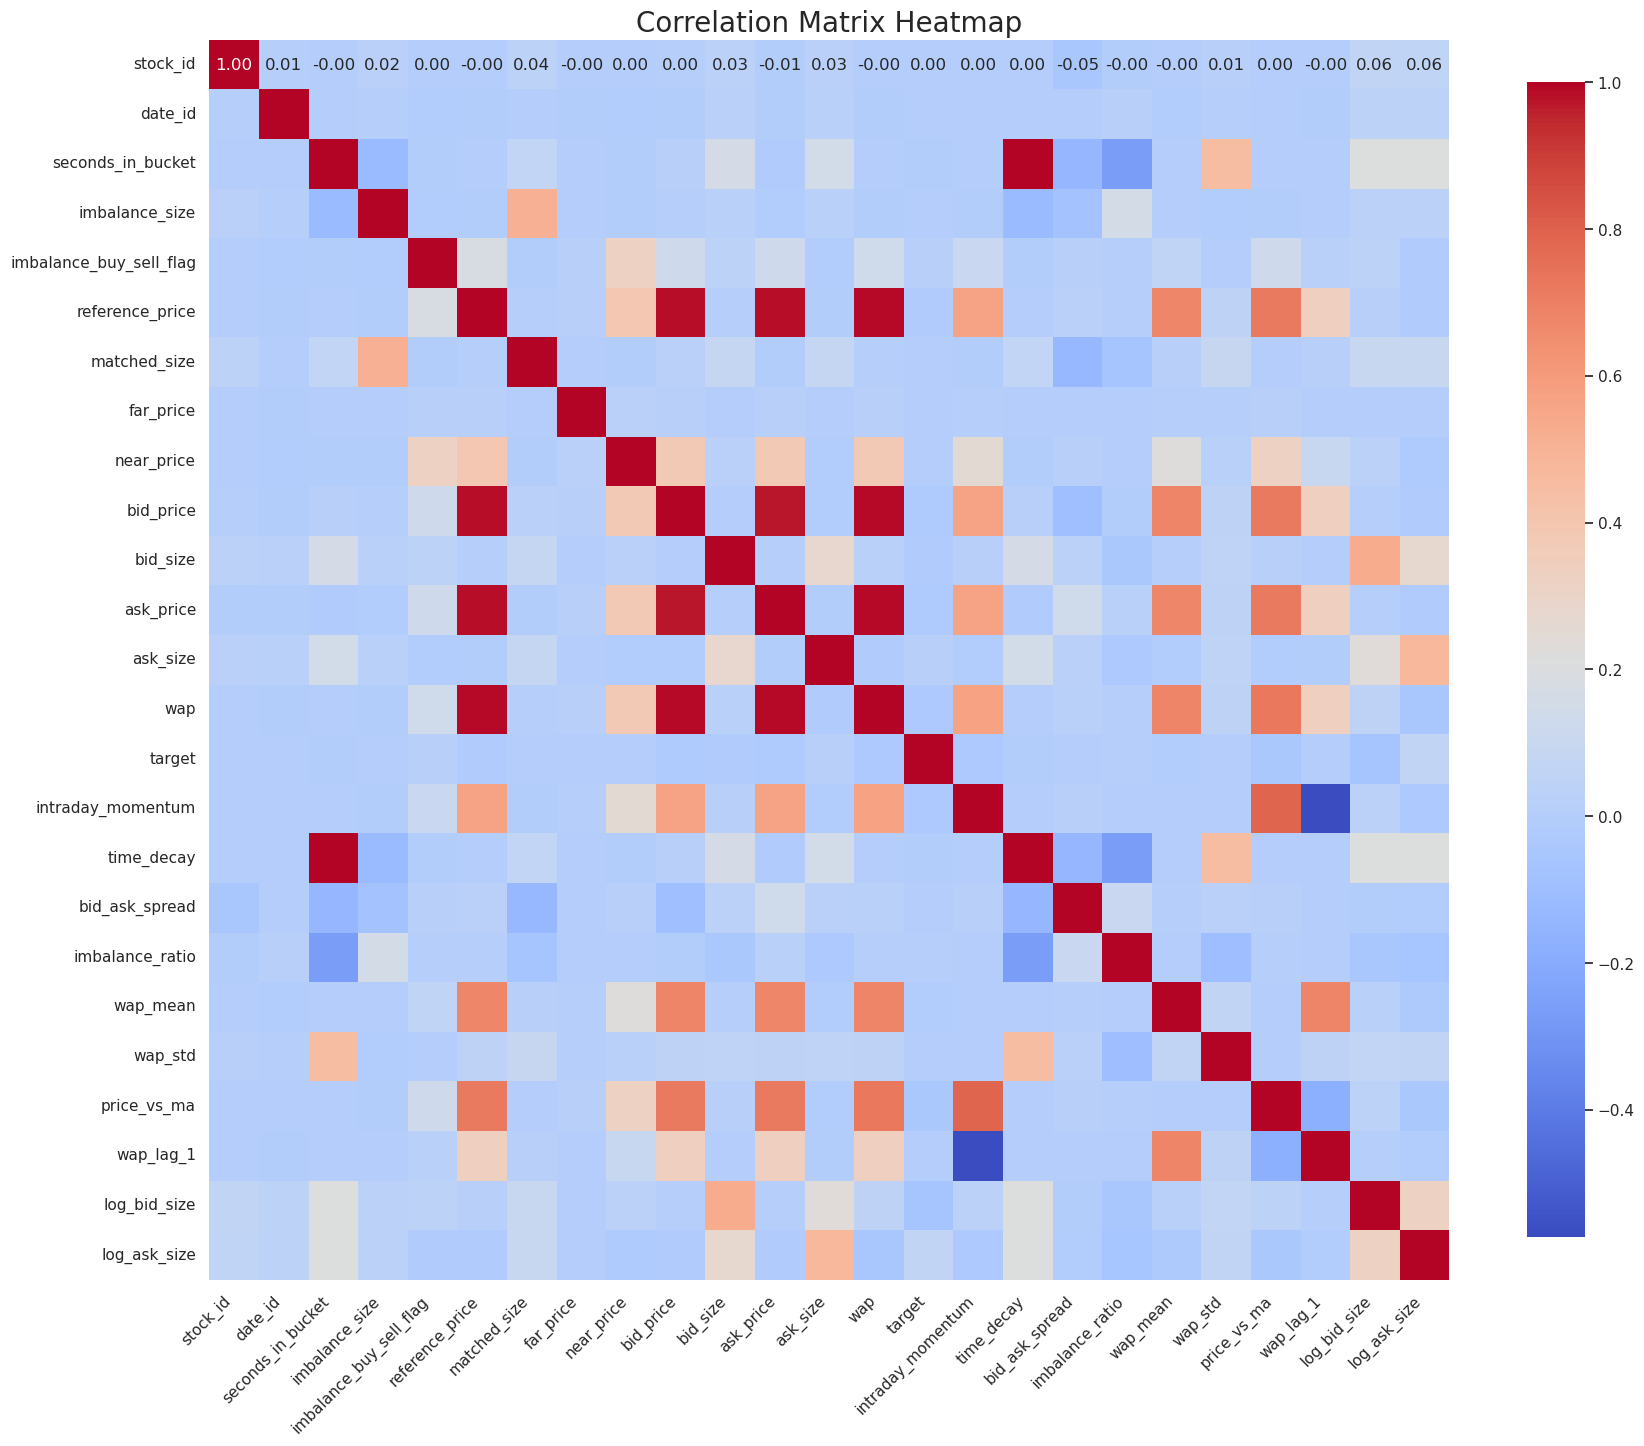

In [8]:
# Generate and display the correlation matrix heatmap
corr_matrix = train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .75})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap', fontsize=20)
plt.show()

In [8]:
X = train.drop(['target'], axis=1)
y = train['target']

In [9]:
# Data Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning:

In [10]:
# Split the data for validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [26]:
# Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(
    iterations=300,
    depth=8,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=False,
    random_seed=42,
    task_type='GPU'
)

# Create a pipeline with feature engineering and CatBoost regressor
pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(create_features)),
    ('regressor', catboost_model)
])

In [27]:
X_train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,intraday_momentum,time_decay,bid_ask_spread,imbalance_ratio,wap_mean,wap_std,price_vs_ma,wap_lag_1,log_bid_size,log_ask_size
0,-1.715665,-1.743353,-1.700840,-0.123541,1.142950,-0.072474,-0.226823,-0.001697,0.012680,0.034293,...,NaN,-0.629745,-0.129311,0.544656,NaN,NaN,NaN,NaN,0.076331,-0.428505
1,-1.698386,-1.743353,-1.700840,-0.270454,-1.116076,-0.039305,-0.310763,-0.001697,0.012680,0.067903,...,0.000000,-0.629745,0.089670,0.870289,NaN,NaN,NaN,0.003222,-0.572714,-0.294215
2,-1.681106,-1.743353,-1.700840,-0.263811,-1.116076,-0.171588,-0.309496,-0.001697,0.012680,-0.129353,...,0.000000,-0.629745,0.142702,0.852389,NaN,NaN,NaN,0.003222,-0.132813,-0.311061
3,-1.663827,-1.743353,-1.700840,0.302336,-1.116076,0.069286,-0.191000,-0.001697,0.012680,0.109115,...,0.000000,-0.629745,-0.129232,-1.582914,NaN,NaN,NaN,0.003222,-0.587271,1.456066
4,-1.646547,-1.743353,-1.700840,-0.256760,-1.116076,-0.183040,-0.194784,-0.001697,0.012680,-0.132954,...,0.000000,-0.629745,0.033952,1.318177,0.003222,0.000000,1.000000,0.003222,-0.381359,-0.529021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190379,1.722973,1.035790,0.881917,-0.106149,-1.116076,-0.625300,-0.163628,-0.092618,-4.174722,-0.525865,...,-0.231436,0.326534,-0.089474,0.648719,-0.101364,0.531763,5.992243,-0.375964,-0.352905,0.140525
4190380,-1.715665,1.035790,0.944911,-0.088438,1.142950,0.258826,-0.060774,0.076027,1.707238,0.293167,...,0.874890,0.349858,-0.100933,1.455204,0.003302,0.545092,81.002563,-0.607399,-0.464299,-0.477224
4190381,-1.698386,1.035790,0.944911,-0.245036,1.142950,1.405545,-0.266590,0.048573,1.152948,1.297051,...,1.129549,0.349858,0.037419,0.919149,0.291756,0.823503,4.788390,0.267491,-0.416606,-0.488408
4190382,-1.681106,1.035790,0.944911,-0.188924,1.142950,0.720041,-0.267110,0.266642,2.857987,0.672474,...,-0.633445,0.349858,0.049643,0.707288,0.288953,0.821457,2.642631,1.397041,-0.141983,-0.371920


In [28]:
# Train the pipeline on the training set
pipeline.fit(X_train, y_train)

# Extract the CatBoost model from the pipeline
trained_catboost_model = pipeline.named_steps['regressor']

In [29]:
# Get feature importances
feature_importances = trained_catboost_model.get_feature_importance()
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", sorted_feature_importance)

Feature Importances:
                     Feature  Importance
16           bid_ask_spread   14.847419
23             log_ask_size    6.196293
22             log_bid_size    6.171686
6              matched_size    6.093801
10                 bid_size    5.978772
12                 ask_size    5.563982
4   imbalance_buy_sell_flag    5.555285
15               time_decay    4.914714
3            imbalance_size    4.682898
2         seconds_in_bucket    4.445976
1                   date_id    3.687961
13                      wap    3.432533
5           reference_price    3.120487
9                 bid_price    3.078296
8                near_price    3.013795
14        intraday_momentum    2.983708
17          imbalance_ratio    2.528111
19                  wap_std    2.491622
11                ask_price    2.310587
18                 wap_mean    2.245744
20              price_vs_ma    2.003727
0                  stock_id    1.796689
7                 far_price    1.502651
21                

In [30]:
# Evaluate the pipeline on the validation set
predictions = pipeline.predict(X_val)
evaluation_metric = mean_absolute_error(y_val, predictions)
print(f"Evaluation Metric (MAE): {evaluation_metric}")

Evaluation Metric (MAE): 5.974901137932725


/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [32]:
print(f"Evaluation Metric (MAE): {evaluation_metric}")

Evaluation Metric (MAE): 5.974901137932725


In [33]:
Feature_cleaning = FunctionTransformer(nan_handler)


pre_trained_pipeline = Pipeline([
    ('feature_cleaning', Feature_cleaning),
    ('pre_trained_model', pipeline)
])
pre_trained_pipeline.predict(test_not_clean)

array([-6.89115886, -9.21927269,  0.74234636, ...,  1.22153167,
        8.28004053,  0.01604214])

In [34]:
dump(pre_trained_pipeline, 'API/app/models/catboost_4_5974.joblib')

['API/app/models/catboost_4_5974.joblib']

## Grid Search

In [20]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import numpy as np

# Assuming your feature creation and preprocessing functions are already defined

# Feature Engineering: Add new features or refine existing ones
X = create_features(X)
X = nan_handler(X)

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a range of hyperparameters for tuning
params = {
    'iterations': [300, 500, 700],
    'depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.15]
}

# Initialize the CatBoost model
catboost_model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=False,
    random_seed=42,
    task_type='GPU'
)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=catboost_model, param_grid=params, scoring='neg_mean_absolute_error', cv=3)
grid_search.fit(X_scaled, y)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)


/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning:

Best Parameters: {'depth': 8, 'iterations': 300, 'learning_rate': 0.05}
Best MAE: 6.301275240953573


## SUBMISSION

In [36]:
pre_trained = load('API/app/models/catboost_4_5974.joblib')
predictions = pre_trained.predict(X_val)
evaluation_metric = mean_absolute_error(y_val, predictions)
print(f"Evaluation Metric (MAE): {evaluation_metric}")

Evaluation Metric (MAE): 5.974901137932725


/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/hugefelix/miniconda3/envs/llm_felix_1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [45]:
submission_csv = pd.concat([pd.read_csv('example_test_files/sample_submission.csv').drop('target', axis=1),
 pd.DataFrame(pre_trained.predict(test_not_clean)).rename(columns = {0:'target'})
], axis = 1)

In [46]:
submission_csv.to_csv('submissions/submission1.csv')